# Import Libraries and Load the Data

In [1]:
import pandas as pd
import numpy as np; np.random.seed(38)
import math
from datetime import datetime

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.layers import TextVectorization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import h5py

In [2]:
# Load data
btc_df = pd.read_csv('BTC_Finale.csv')

In [3]:
btc_df.date = pd.to_datetime(btc_df.date, infer_datetime_format=True)

In [4]:
btc_df.head()

,date,open,high,low,close,volume,price_var,news,trend
0,2021-01-25 16:00:00,34188.20,34885.56,33616.56,33901.01,136344.59,-0.008400,none,1.0
1,2021-01-25 20:00:00,33901.01,34262.94,33055.00,33476.34,133618.13,-0.012527,none,1.0
2,2021-01-26 00:00:00,33476.34,33476.34,31775.00,32518.40,128086.22,-0.028615,none,1.0
3,2021-01-26 04:00:00,32518.40,32850.88,31459.59,32038.79,127412.83,-0.014749,none,1.0
4,2021-01-26 08:00:00,32038.79,32353.33,31149.86,31914.98,125831.07,-0.003864,none,1.0


# Model Definition

**We try to solve two different tasks:**
- price prediction based on Volume and previous Close value.
- trend prediction depending on news.

For first task LSTM Model would be used. It proved to be good for such problems.
As for trend prediction, we will use Text Vectorization with labels to solve classification problem.

## LSTM Model - Task 1

### Batch-size and trainings-set size

With stateful LSTMs the trainings-set size must be divisible without remainder by the batch-size

In [5]:
# Defining the batch size and the number of epochs
batch_size = 64
epochs = 160
timesteps = 30 # 5 days for 4-hour time frame

In [6]:
# Create MinMaxScalers. We need 2 because array dimensions is different.
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()

Function to split data to train and test.

In [7]:
# Construct train and test sets
def get_train_length(df, test_percent):
    
    # Number of features
    df_c_len = len(df.columns)
    df = df.values
    
    # Define arrays
    X_train = []
    y_train = []
    X_test = []
    
    ###
    
    # Substract test_percent to be excluded from training, reserved for testset
    train_raw_length = np.floor(len(df) *  (1 - test_percent)).astype(int)
    remainder = train_raw_length % batch_size
    # The value is now a multiple of batch_size
    train_length = train_raw_length - remainder
    upper_train = train_length + timesteps*2
    
    # Find test_length and upper_test for testset
    test_raw_length = np.floor(len(df) - timesteps*2 - upper_train).astype(int)
    remainder = test_raw_length % batch_size
    # The value is now a multiple of batch_size
    test_length = test_raw_length - remainder
    upper_test = upper_train + test_length + timesteps*2
    
    # Real price values
    real_price = []
    real_price = df[upper_train:upper_test,[df_c_len-1]]
    scaler2.fit_transform(real_price)
    
    ###
    
    # Subsetting training and test sets
    train_set = df[:upper_train]
    test_set = df[upper_train:upper_test]
       
    # Scaling
    train_scaled = scaler.fit_transform(np.float64(train_set))
    test_scaled = scaler.fit_transform(np.float64(test_set))
        
    ###
    
    # Creating a data structure with n timesteps
    for i in range(timesteps, upper_train - timesteps): 
        X_train.append(train_scaled[i-timesteps:i,:])
        y_train.append(train_scaled[i:i+timesteps,[-1]])
        
    for i in range(timesteps, upper_test - upper_train - timesteps):
        X_test.append(test_scaled[i-timesteps:i,:])
        
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(real_price)

Call the function.

In [8]:
X_train, X_test, y_train, real_price = get_train_length(btc_df[['volume','close']], 0.15)

In [9]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1856, 30, 2)
(1856, 30, 1)
(256, 30, 2)


### Initialising the Model

In [10]:
model = Sequential()
model.add(LSTM(10, stateful=True, return_sequences=True,
               batch_input_shape=(batch_size,timesteps,2))
)
model.add(LSTM(10, stateful=True, return_sequences=True))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (64, 30, 10)              520       
                                                                 
 lstm_1 (LSTM)               (64, 30, 10)              840       
                                                                 
 dense (Dense)               (64, 30, 1)               11        
                                                                 
Total params: 1,371
Trainable params: 1,371
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Statefull
for i in range(epochs):
    # Run through all data but the cell, hidden state are used for the next batch.
    model.fit(X_train, y_train, shuffle=False, verbose=1,
                      epochs=1, batch_size=batch_size)
    # Resets only the states. The weights, cell and hidden are kept.
    model.reset_states() 

29/29 [==============================] - 0s 7ms/step - loss: 0.0863 - mse: 0.0124


In [12]:
# Predict price
y_hat = model.predict(X_test, batch_size=batch_size)
model.reset_states()

In [13]:
# Reshaping
y_hat = np.reshape(y_hat, (y_hat.shape[0], y_hat.shape[1]))
# Inverse transform
y_hat = scaler2.inverse_transform(y_hat)
#creating y_test data
y_test = []
for j in range(0, len(X_test) - timesteps):
    y_test = np.append(y_test, y_hat[j, timesteps-1])
# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))
print(y_test.shape)

(226, 1)


Let's visualize the results

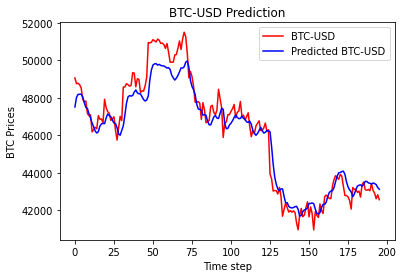

In [14]:
plt.plot(real_price[timesteps:len(y_test)].astype(float), color = 'red', label = 'BTC-USD')
plt.plot(y_test[0:len(y_test) - timesteps].astype(float), color = 'blue', label = 'Predicted BTC-USD')
plt.title('BTC-USD Prediction')
plt.xlabel('Time step')
plt.ylabel('BTC Prices')
plt.legend()
plt.show()

### MSE (mean sqared error)

In [15]:
mse = math.sqrt(mean_squared_error(real_price[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
mse

766.7210288597211

The result is good. It's can be clearly seen than price tend to move around predicted values.

---

## Text Model - Task 2

### Text vectorization fot train and test sets.

Define train and test sets.

In [22]:
# We will only use data which have news.
btc_df_ = btc_df[btc_df.news != 'none']

# 15% is dedicated for test.
dev_len = int(len(btc_df_) * 0.85)

X_train = btc_df_.news[:dev_len].values
y_train = btc_df_.trend[:dev_len].values
X_test= btc_df_.news[dev_len:-30].values
y_test = btc_df_.trend[dev_len:-30].values

In [23]:
# Vectorize the text
vectorizer = TextVectorization()
vectorizer.adapt(X_train)
X_train_ = vectorizer(X_train)
X_test_ = vectorizer(X_test)

In [24]:
# Truncate and pad input sequences
max_length = 120
X_train_ = sequence.pad_sequences(X_train_, maxlen=max_length)
X_test_ = sequence.pad_sequences(X_test_, maxlen=max_length)

### Initialising the Model

In [25]:
embedding_vecor_length=32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 32)           160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 60, 32)           0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
________________________________________________

### Accuracy measurement

In [26]:
model.fit(X_train_, y_train, epochs=30, batch_size=64, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test_, y_test, verbose=1)

Epoch 1/30
17/17 [==============================] - 2s 29ms/step - loss: 1.0393 - accuracy: 0.5185
Epoch 2/30
17/17 [==============================] - 0s 29ms/step - loss: 0.7069 - accuracy: 0.4658
Epoch 3/30
17/17 [==============================] - 0s 29ms/step - loss: 0.6930 - accuracy: 0.5296
Epoch 4/30
17/17 [==============================] - 0s 29ms/step - loss: 0.6925 - accuracy: 0.5323
Epoch 5/30
17/17 [==============================] - 0s 29ms/step - loss: 0.6908 - accuracy: 0.5342
Epoch 6/30
17/17 [==============================] - 0s 29ms/step - loss: 0.6900 - accuracy: 0.5222
Epoch 7/30
17/17 [==============================] - 0s 29ms/step - loss: 0.6909 - accuracy: 0.5231
Epoch 8/30
17/17 [==============================] - 1s 29ms/step - loss: 0.6866 - accuracy: 0.5055
Epoch 9/30
17/17 [==============================] - 0s 29ms/step - loss: 0.6938 - accuracy: 0.6608
Epoch 10/30
17/17 [==============================] - 0s 28ms/step - loss: 0.7198 - accuracy: 0.7569
Epoch 11/

The accuracy above 50% which isn't impressive by itself, but prof the point that news can be used for trading strategy tunning.

In [27]:
# Save model
# moedl.save(filepath="model_ts.h5")

# Load model
# model = load_model(filepath="model_ts.h5")

# Сonclusions

The study showed the possibility of using machine learning methods to create a trading system or bot.